<a href="https://colab.research.google.com/github/reidnclark/MFDPRepo/blob/main/MFDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Multipurpose Financial Data Processor (MFDP)**

---
##### Author: Reid Clark
##### Date: December 20, 2023
---
##### Import Libraries:

In [567]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from babel.numbers import format_currency, format_percent

## 1) **Inputs**
---

##### Input Arguments:

In [568]:
ticker_input = 'NTR' # Nutrien
test_ticker_assert = yf.Ticker(ticker_input)

financial_attributes_input = ['EBITDA']
cashflow_attributes_input = ['Free Cash Flow']
balsheet_attributes_input = ['Total Debt']
basic_attributes_input = ['beta', 'marketCap', 'sharesOutstanding']

## 2) **Fundamental Analysis**
---

##### Get Data Function:

In [569]:
# Basic Data, e.g. Market Cap, Beta...
def get_basic_data(attributes_data: dict, attributes_input: list[str]) -> dict:
    basic_data_dict = {}
    for attr in attributes_input:
      basic_data_dict[attr] = attributes_data.get(attr)
    return basic_data_dict

# Retrieve Historical Data, e.g. Cash Flow info, Balance Sheet info...
def get_attr_hist_data(attributes_data: pd.DataFrame, attributes_input: list[str]) -> dict:
    for attr in attributes_input:
      attr_hist_data = attributes_data.loc[attr].dropna()
    return attr_hist_data

# Perform future Free Cash Flow and EBITDA forecasts...
def forecast(attr_hist_data: pd.Series) -> list[float]:
    initial_value = attr_hist_data.iloc[-1]
    ending_value = attr_hist_data.iloc[0]

    # compound annual growth rate
    cagr = ((ending_value / initial_value)**(1/len(attr_hist_data))) - 1
    print(f'Compounded annual {attr_hist_data.name} growth rate: {(cagr.real*100):.2f}%')

    forecasted_list = []
    for i in range(len(attr_hist_data)):
      forecast_value = ending_value * ((1+cagr)**(i+1))
      forecasted_list.append(forecast_value)
    return forecasted_list

def get_data(ticker_input: tuple,
             financial_attributes_input: list[str],
             cashflow_attributes_input: list[str],
             balsheet_attributes_input: list[str],
             basic_attributes_input: list[str]) -> tuple[list[float],
                                                         list[float],
                                                         float, dict,
                                                         yf.Ticker]:

  yf_ticker = yf.Ticker(ticker_input)

  # access yfinance financial attributes (For this code, we just need the 'EBITDA' metric)
  # EBITDA = Earnings before Interest, Tax, Deductions & Amortization (Loan Payments)
  financial_attributes = yf_ticker.financials
  financial_attributes_hist_data = get_attr_hist_data(financial_attributes, financial_attributes_input)
  forecasted_list_financials = forecast(financial_attributes_hist_data)

  # access yfinance data from company's cash flow statement (we just need the 'Free Cash Flow' metric)
  cashflow_attributes = yf_ticker.cashflow
  cashflow_attributes_hist_data = get_attr_hist_data(cashflow_attributes, cashflow_attributes_input)
  forecasted_list_cashflow = forecast(cashflow_attributes_hist_data)

  # access yfinance balance sheet data for company (we just need 'Total Debt')
  balsheet_attributes = yf_ticker.balance_sheet
  balsheet_attributes_hist_data = get_attr_hist_data(balsheet_attributes, balsheet_attributes_input).iloc[0]

  # basic summary information for company (we need the 'beta', 'marketCap' and 'sharesOutstanding' )
  basic_attributes = yf_ticker.info
  basic_attributes_hist_data = get_basic_data(basic_attributes, basic_attributes_input)

  return forecasted_list_financials, forecasted_list_cashflow, balsheet_attributes_hist_data, basic_attributes_hist_data, yf_ticker

forecasted_list_financials, forecasted_list_cashflow, balsheet_attributes_hist_data, basic_attributes_hist_data, yf_ticker = get_data(ticker_input,
                                                                           financial_attributes_input,
                                                                           cashflow_attributes_input,
                                                                           balsheet_attributes_input,
                                                                           basic_attributes_input
                                                                                      )

ticker = yf_ticker
total_cash = (yf_ticker.balance_sheet.loc['Cash And Cash Equivalents'].iloc[0])
total_equity = (test_ticker_assert.balance_sheet).loc['Stockholders Equity'].iloc[0]
total_debt = balsheet_attributes_hist_data
interest_expenses = (yf_ticker.income_stmt.loc['Interest Expense'].iloc[0])
cost_of_debt = interest_expenses / total_debt
total_shares = basic_attributes_hist_data['sharesOutstanding']
beta = basic_attributes_hist_data['beta']
market_cap = basic_attributes_hist_data['marketCap']
ticker_name = ticker.info.get('longName')

Compounded annual EBITDA growth rate: 14.00%
Compounded annual Free Cash Flow growth rate: 7.79%


## 3) **Instant DCF Model**
---

## Computes the Expected Return ( *E ( x )*  ) of an investment given:
---

##### 1. Risk-free interest Rate ( **R$_f$** ), the % Yield on a 1-yr Government Bond (Canada).
##### 2. Beta ( ***&beta;*** ), the price volatility compared to the S&P 500.
##### 3. Expected Market Return ( **R$_m$** ), the % 1-yr return of the S&P 500.




##### Use **CAPM** Formula Function:
---
#### Capital Asset Pricing Model
---
###### Contributions: *Markowitz, H.* (1952), *Sharpe, W.* (1964)
###### Variations: Fama-French (1992), Carhart (1997)

### $$ E(R_i) = R_f + \beta_i (E(R_m) - R_f) $$

In [570]:
r_f = 4.75 / 100 # risk-free rate ( return subscript f, % )
b_i = beta # beta ( beta subscript i, ration )
e__r_m = 0.10 # expected market return ( e(return subscript m, %) )

e__r_i = r_f + b_i*(e__r_m - r_f) # expected return on investment
print(f"Expected Return of {ticker.info.get('longName')}: {(e__r_i*100):.2f}%")

Expected Return of Nutrien Ltd.: 9.76%


---
##### **WACC** Formula Function:
---
#### Weighted Average Cost of Capital
---
###### Contributions: *Modigliani, F. & Miller, M. (1958)*

### $$ WACC = \frac{E}{V} \cdot r_e + \frac{D}{V} \cdot r_d \cdot (1 - T) $$

In [571]:
E = total_equity
D = total_debt
R_e = e__r_i # capm result
R_d = cost_of_debt
T = 0.25 # tax rate

wacc = (E / (E+D))*R_e + (D / (E+D))*R_d*(1-T) # weighted average cost of capital
print(f"Minimum Break-Even Return for {ticker.info.get('longName')}: {(wacc*100):.2f}%")
# to cover cost of capital expenditures

Minimum Break-Even Return for Nutrien Ltd.: 8.03%


#### **Terminal Value (TV)** Formula Function:

---

In [572]:
fcf_n = forecasted_list_cashflow[-1] # value of final year in fcf forecast
g = 0.03 # perpetual growth rate (can use GDP growth estimate per year, (3 %), or ind.)
tv = (fcf_n * (1+g)) / (wacc - g)

def format_dollar(amount):
    """Format an integer as a dollar amount."""
    return f"${amount:,.2f}"

print(f"Estimated Intrinsic Value, {ticker.info.get('longName')}: {format_dollar(tv)}")
print(f"Current Value, {ticker.info.get('longName')}: {format_dollar(market_cap)}")
# in later version, add in tv financial metric multiple to find average. for now can just use perp.

Estimated Intrinsic Value, Nutrien Ltd.: $66,253,359,072.12
Current Value, Nutrien Ltd.: $23,911,153,664.00


#### **Discount Back to Present Function** and **Enterprise Valuation**:

---

In [573]:
#print(format_dollar(i) for i in forecasted_list_cashflow)
pv_of_fcfs = []
discount_factors = []

for i in range(len(forecasted_list_cashflow)):
  discount_factor = (1 / ((1+wacc)**(i+1)))
  discount_factors.append(discount_factor)
  fcf_at_i = discount_factor * forecasted_list_cashflow[i]
  pv_of_fcfs.append(fcf_at_i)

pv_of_tv = discount_factors[-1]*tv
enterprise_value = (sum(pv_of_fcfs)) + pv_of_tv
equity_value = enterprise_value - total_debt + total_cash
share_price = equity_value / total_shares

### **Print Results (Estimated Share Price):**
---

In [574]:
intrinsic_price = share_price.real

print(f'{ticker_name} Intrinsic Price: ${intrinsic_price:.2f}')
print('---------------------------------------------------------')
current_price = yf_ticker.history(period='1d')['Close'].iloc[0]
print(f'{ticker_name} Current Price: ${current_price:.2f}')
print('---------------------------------------------------------')

difference = 1 - (current_price / intrinsic_price)
print(f'Margin of Difference: {difference*100:.2f}%')

print('---------------------------------------------------------')
if current_price < intrinsic_price:
  print('BUY (ASSUMES NO MARGIN OF SAFETY. SEE FOLLOWING CODE FOR MARGIN CALCULATION AND RE-RESULT.)')
else:
  print('SHORT (ASSUMES NO MARGIN OF SAFETY. SEE FOLLOWING CODE FOR MARGIN CALCULATION AND RE-RESULT.)')

Nutrien Ltd. Intrinsic Price: $94.09
---------------------------------------------------------
Nutrien Ltd. Current Price: $47.90
---------------------------------------------------------
Margin of Difference: 49.09%
---------------------------------------------------------
BUY (ASSUMES NO MARGIN OF SAFETY. SEE FOLLOWING CODE FOR MARGIN CALCULATION AND RE-RESULT.)


## 4) **Compute Price Activity & Plot Standard Deviations**
---

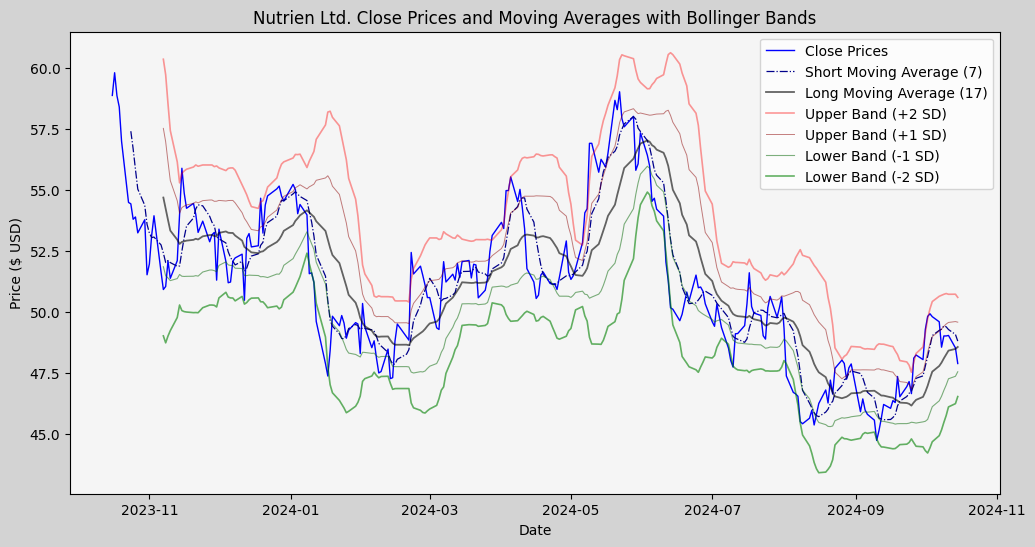

In [576]:
# Plotting section
# Fetch historical price data for the ticker
ticker_histdata = yf.Ticker(ticker_input).history(period='1y')
close_prices = ticker_histdata['Close']

# Moving averages
moving_avg_interval_long = 17  # Long moving average interval
moving_avg_interval_short = 7   # Short moving average interval

def moving_avg(arr, interval):
    moving_avg_list = []
    for index in range(len(arr) - interval + 1):
        window = arr[index:index + interval]
        avg = window.mean()
        moving_avg_list.append(avg)
    return np.concatenate([np.full(interval - 1, np.nan), moving_avg_list])

moving_avg_long_stretched = moving_avg(close_prices, moving_avg_interval_long)
moving_avg_short_stretched = moving_avg(close_prices, moving_avg_interval_short)

# Calculate standard deviation for Bollinger Bands
def calculate_stddev(arr, interval):
    stddev_list = []
    for index in range(len(arr) - interval + 1):
        window = arr[index:index + interval]
        stddev = window.std()
        stddev_list.append(stddev)
    return np.concatenate([np.full(interval - 1, np.nan), stddev_list])

stddev_long = calculate_stddev(close_prices, moving_avg_interval_long)

# Calculate Bollinger Bands
upper_band_1 = moving_avg_long_stretched + stddev_long
lower_band_1 = moving_avg_long_stretched - stddev_long
upper_band_2 = moving_avg_long_stretched + (2 * stddev_long)
lower_band_2 = moving_avg_long_stretched - (2 * stddev_long)

# Plotting the historical close prices and moving averages
plt.figure(figsize=(12, 6), facecolor='lightgrey')
plt.gca().set_facecolor('whitesmoke')
plt.plot(close_prices.index, close_prices, label='Close Prices',
         color='blue', linewidth=1)
plt.plot(close_prices.index, moving_avg_short_stretched, label=f'Short Moving Average ({moving_avg_interval_short})',
         color='darkblue', linewidth=.9, linestyle='-.')
plt.plot(close_prices.index, moving_avg_long_stretched, label=f'Long Moving Average ({moving_avg_interval_long})',
         color='black', linewidth=1.3, linestyle='-',alpha=0.6)

# Plotting Bollinger Bands
plt.plot(close_prices.index, upper_band_2, label='Upper Band (+2 SD)',
         color='red', linestyle='-', linewidth=1.2, alpha=0.4)
plt.plot(close_prices.index, upper_band_1, label='Upper Band (+1 SD)',
         color='darkred', linestyle='-', linewidth=0.7, alpha=0.5)
plt.plot(close_prices.index, lower_band_1, label='Lower Band (-1 SD)',
         color='darkgreen', linestyle='-', linewidth=0.8, alpha=0.5)
plt.plot(close_prices.index, lower_band_2, label='Lower Band (-2 SD)',
         color='green', linestyle='-', linewidth=1.2, alpha=0.6)

plt.title(f'{ticker_name} Close Prices and Moving Averages with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price ($ USD)')
plt.legend()
plt.show()

---
#### Sample Long Portfolio:
---
- ##### ASSA ABLOY AB - PNK:ASAZY - Industrial Security Services
- ##### Quebecor Inc. - TOR:QBR-B.TO - Telecommunications
- ##### Nutrien Ltd. - NYQ:NTR -  Agricultural Materials
- ##### ERO Copper Corp. - TOR:ERO.TO - Copper
- ##### Canadian Natural Resources Limited - TOR:CNQ.TO - Oil & Gas
- ##### Taiwan Semiconductor Manufacturing - NYQ:TSM - Semiconductors
- ##### Netflix, Inc. - NMS:NFLX - Entertainment
- ##### Procter & Gamble - NYQ:PG - Household & Personal Products
- ##### HOYA Corporation - PNK:HOCPY - Healthcare Instruments
- ##### Atlas Copco AB - STO:ATCO-B.ST - Industrial Machinery

---
##### Long Portfolio, Missing Data:
---
- ##### Hitachi, Ltd. - JPX:6501.T - Industrial Conglomerates

---
Investigate further

---
- Samsung Electronics Co., Ltd. (005930.KS)

---
Maybe Long

---
- ##### ASML Holding NV - NMS:ASML - Semiconductors
- ##### Restaurant Brands International - NYQ:QSR
- ##### ResMed Inc. - NYQ:RMD
- ##### Cenovus Energy Inc. - NYQ:CVE - Oil & Gas
- ##### Dollarama Inc. - TOR:DOL.TO
- ##### Shin-Etsu Chemical, Co., Ltd. - PNK:SHECY
- ##### Siemens Energy AG - PNK:SMEGF
---
Maybe Short

---
- ##### George Weston Limited - TOR:WN.TO - Grocery Stores

---
Distressed?

---